## sklearn contains sparese representation 

In [56]:
import numpy as np
import random
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio

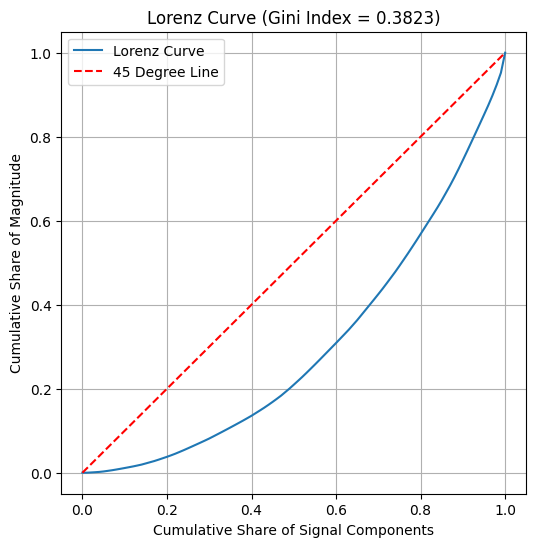

Gini Index: 0.3823


In [57]:

# Function to generate the signal
def generate(N, K, mu=0, sigma=100):
    """
    Generates a sparse signal with N components and K non-zero values.
    The non-zero values are drawn from a normal distribution with mean `mu` and standard deviation `sigma`.
    """
    signal = np.zeros(N)
    indexes = random.sample(range(0, N), K)
    signal[indexes] = np.random.normal(mu, sigma, K)
    return signal

# Function to compute the Lorenz curve
def lorenz_curve(signal):
    """
    Computes the Lorenz curve for a given signal.
    The signal should be a 1D numpy array.
    """
    sorted_signal = np.sort(np.abs(signal))  # Sort the signal in ascending order
    cumulative_sum = np.cumsum(sorted_signal)  # Cumulative sum of sorted signal
    lorenz = cumulative_sum / cumulative_sum[-1]  # Normalize to get the Lorenz curve
    return lorenz

# Function to compute A(x) from the Lorenz curve
def A(lorenz):
    """
    Computes the area A(x) under the Lorenz curve using the formula:
    A(x) = 1 / (2N) * sum(L(n-1/N) + L(n/N)) for all n
    """
    N = len(lorenz)
    area = 0
    for n in range(1, N+1):
        area += (lorenz[n-1] + lorenz[n-1 if n == N else n]) / N
    return 0.5 * area

# Function to compute the Gini index from a Lorenz curve
def gini_index(lorenz):
    """
    Computes the Gini index based on the Lorenz curve using the area A(x).
    The Gini index is calculated as 1 - 2 * A(x).
    """
    area = A(lorenz)
    gini = 1 - 2 * area
    return gini

# Function to plot the Lorenz curve
def plot_lorenz_curve(signal):
    """
    Plots the Lorenz curve for a given signal and also shows the Gini index.
    """
    lorenz = lorenz_curve(signal)
    gini = gini_index(lorenz)
    
    # Plotting the Lorenz curve
    plt.figure(figsize=(6, 6))
    plt.plot(np.linspace(0, 1, len(lorenz)+1), np.concatenate(([0], lorenz)), label="Lorenz Curve")
    plt.plot([0, 1], [0, 1], label="45 Degree Line", linestyle='--', color='red')
    plt.title(f"Lorenz Curve (Gini Index = {gini:.4f})")
    plt.xlabel("Cumulative Share of Signal Components")
    plt.ylabel("Cumulative Share of Magnitude")
    plt.legend()
    plt.grid(True)
    plt.show()

    return gini


N=100
K= 100
mu=0
sigma=1
# Example of usage
signal = generate(N, K, mu, sigma)
gini_index_value = plot_lorenz_curve(signal)
print(f"Gini Index: {gini_index_value:.4f}")


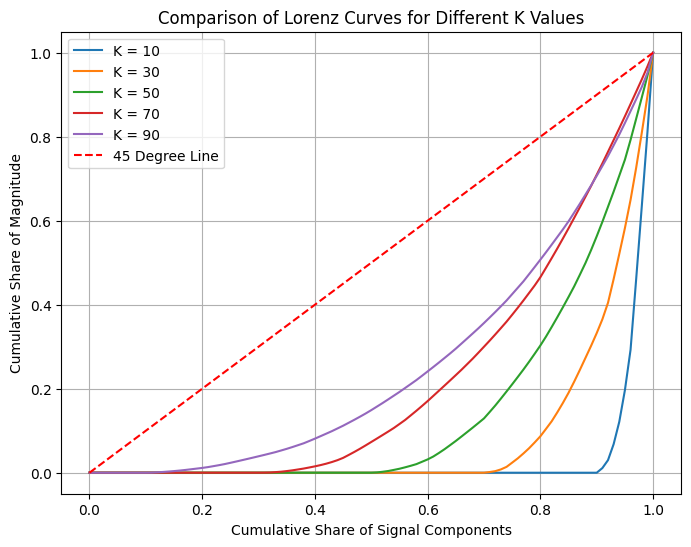

In [58]:
K_values=[10, 30, 50, 70, 90]
# Function to plot multiple Lorenz curves for different values of K
def plot_multiple_lorenz_curves(N=N, K_values=K_values, mu=mu, sigma=sigma):
    """
    Plots Lorenz curves for multiple values of K on the same graph for comparison.
    """
    plt.figure(figsize=(8, 6))

    for K in K_values:
        signal = generate(N, K, mu, sigma)  # Generate the signal for each K
        lorenz = lorenz_curve(signal)  # Compute the Lorenz curve for the generated signal
        plt.plot(np.linspace(0, 1, len(lorenz)+1), np.concatenate(([0], lorenz)), label=f"K = {K}")

    plt.plot([0, 1], [0, 1], label="45 Degree Line", linestyle='--', color='red')
    plt.title("Comparison of Lorenz Curves for Different K Values")
    plt.xlabel("Cumulative Share of Signal Components")
    plt.ylabel("Cumulative Share of Magnitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of usage: plot Lorenz curves for K = 1, 3, 5, 7, 9
plot_multiple_lorenz_curves(N, K_values)

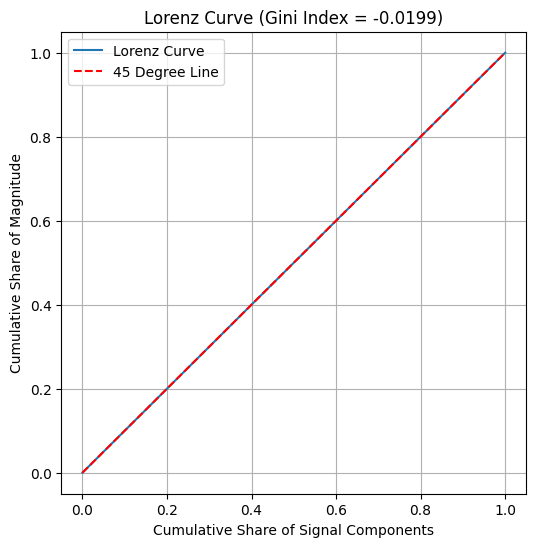

-0.01990000000000003

In [59]:
plot_lorenz_curve(np.ones(N))

In [60]:

# Function to verify the Robin Hood principle
def robin_hood_property(signal):
    """
    Verifies the Robin Hood principle and returns the previous and new Gini index.
    The new strategy is to redistribute wealth more evenly among the signal.
    """
    sorted_signal = np.sort(signal)
    redistributed_signal = np.copy(sorted_signal)
    # Redistribute wealth more evenly (balance the extremes)
    for i in range(len(sorted_signal)//2):
        redistributed_signal[i] = (sorted_signal[i] + sorted_signal[-i-1]) / 2
        redistributed_signal[-i-1] = redistributed_signal[i]
    
    # Compute the Gini index before and after redistribution
    gini_before = gini_index(lorenz_curve(signal))
    gini_after = gini_index(lorenz_curve(redistributed_signal))
    return gini_before, gini_after

# Function to verify scale invariance
def scale_invariance_property(signal, scale_factor=2):
    """
    Verifies scale invariance and returns the previous and new Gini index.
    """
    scaled_signal = signal * scale_factor  # Scale the signal by a factor
    gini_before = gini_index(lorenz_curve(signal))
    gini_after = gini_index(lorenz_curve(scaled_signal))
    return gini_before, gini_after

# Function to verify adding a constant decreases sparsity
def adding_constant_property(signal, constant_value=10):
    """
    Verifies that adding a constant to the signal decreases sparsity and returns the previous and new Gini index.
    """
    new_signal = signal + constant_value  # Add a constant to the signal
    gini_before = gini_index(lorenz_curve(signal))
    gini_after = gini_index(lorenz_curve(new_signal))
    return gini_before, gini_after

# Function to verify cloning property
def cloning_property(signal):
    """
    Verifies the cloning property and returns the previous and new Gini index.
    We will clone the signal by shuffling it and appending to the original to simulate real-world behavior.
    """
    cloned_signal = np.concatenate([signal, np.random.permutation(signal)])  # Clone and shuffle the signal
    gini_before = gini_index(lorenz_curve(signal))
    gini_after = gini_index(lorenz_curve(cloned_signal))
    return gini_before, gini_after

# Function to verify Bill Gates property
def bill_gates_property(signal, large_value=1e5):
    """
    Verifies that making one component infinitely large increases sparsity and returns the previous and new Gini index.
    """
    large_signal = np.copy(signal)
    large_signal[0] += large_value  # Make the first element very large
    gini_before = gini_index(lorenz_curve(signal))
    gini_after = gini_index(lorenz_curve(large_signal))
    return gini_before, gini_after

# Function to verify Babies property
def babies_property(signal, num_babies=5):
    """
    Verifies that adding zero values (babies) to the signal increases sparsity and returns the previous and new Gini index.
    """
    babies_signal = np.concatenate([signal, np.zeros(num_babies)])  # Add zero values (babies)
    gini_before = gini_index(lorenz_curve(signal))
    gini_after = gini_index(lorenz_curve(babies_signal))
    return gini_before, gini_after

# Example of usage
signal = generate(N, K)

# Verify properties and print Gini index values before and after changes
robin_hood_before, robin_hood_after = robin_hood_property(signal)
print(f"Robin Hood Property - Gini before: {robin_hood_before:.4f}, Gini after: {robin_hood_after:.4f}")
print("This property is verified." if robin_hood_before >= robin_hood_after else "This property is not verified.")

scale_before, scale_after = scale_invariance_property(signal)
print(f"Scale Invariance Property - Gini before: {scale_before:.4f}, Gini after: {scale_after:.4f}")
print("This property is verified." if np.isclose(scale_before, scale_after) else "This property is not verified.")

constant_before, constant_after = adding_constant_property(signal)
print(f"Adding Constant Property - Gini before: {constant_before:.4f}, Gini after: {constant_after:.4f}")
print("This property is verified." if constant_before > constant_after else "This property is not verified.")

cloning_before, cloning_after = cloning_property(signal)
print(f"Cloning Property - Gini before: {cloning_before:.4f}, Gini after: {cloning_after:.4f}")
print("This property is verified." if 0.8< cloning_before/ cloning_after<1.2 else "This property is not verified.")

bill_gates_before, bill_gates_after = bill_gates_property(signal)
print(f"Bill Gates Property - Gini before: {bill_gates_before:.4f}, Gini after: {bill_gates_after:.4f}")
print("This property is verified." if bill_gates_after > bill_gates_before else "This property is not verified.")

babies_before, babies_after = babies_property(signal)
print(f"Babies Property - Gini before: {babies_before:.4f}, Gini after: {babies_after:.4f}")
print("This property is verified." if babies_after > babies_before else "This property is not verified.")


Robin Hood Property - Gini before: 0.3816, Gini after: 0.2028
This property is verified.
Scale Invariance Property - Gini before: 0.3816, Gini after: 0.3816
This property is verified.
Adding Constant Property - Gini before: 0.3816, Gini after: 0.3885
This property is not verified.
Cloning Property - Gini before: 0.3816, Gini after: 0.3916
This property is verified.
Bill Gates Property - Gini before: 0.3816, Gini after: 0.9257
This property is verified.
Babies Property - Gini before: 0.3816, Gini after: 0.4111
This property is verified.


In [61]:

import eyed3

# Load the MP3 file
audio_path = 'common_voice_en_41910277.mp3'
audio_file = eyed3.load(audio_path)

# Get the sampling rate
sampling_rate = audio_file.info.sample_freq
print(f"Sampling Rate: {sampling_rate} Hz")
sr= 32000

Sampling Rate: 32000 Hz


In [62]:


# Load an MP3 file
audio_path = 'common_voice_en_41910277.mp3'
audio, sr = librosa.load(audio_path, sr=sr)  # sr is the sample rate (set to 16kHz)
print(f"Audio shape: {audio.shape}, Sample rate: {sr}")
Audio(audio, rate=sr)


Audio shape: (122112,), Sample rate: 32000


In [63]:
# Compute Short-Time Fourier Transform (STFT)
D = librosa.stft(audio, n_fft=1024, hop_length=512)

# Correcting the amplitude to dB conversion by taking the absolute value of the STFT result
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)



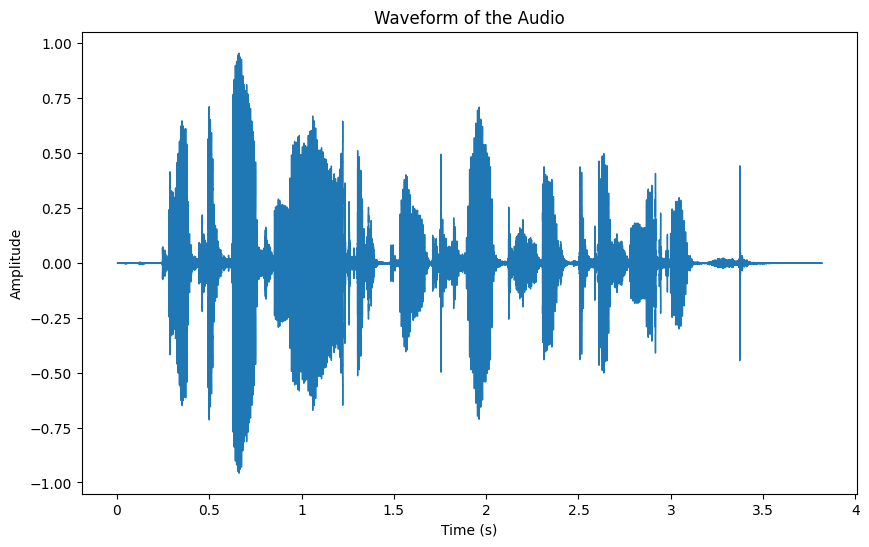

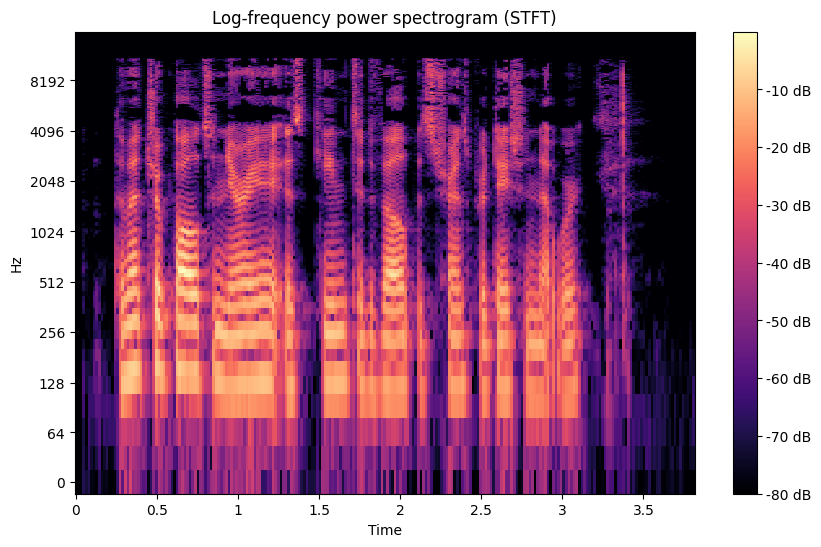

Gini index for different window types: {'hann': 0.11704107177812029, 'hamming': 0.117153027559601, 'triang': 0.11570741525769324, 'boxcar': 0.12963020310830542}


In [64]:
# Compute Short-Time Fourier Transform (STFT)
D = librosa.stft(audio, n_fft=1024, hop_length=512)

# Correcting the amplitude to dB conversion by taking the absolute value of the STFT result
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the waveform of the audio
plt.figure(figsize=(10, 6))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot the spectrogram (Log-frequency power spectrogram)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram (STFT)')
plt.show()

# Function to calculate the Gini index (Gini for a signal)
def gini_index(signal):
    sorted_signal = np.sort(np.abs(signal))
    cumulative_sum = np.cumsum(sorted_signal)
    lorenz = cumulative_sum / cumulative_sum[-1]  # Normalize to get Lorenz curve
    area = np.sum(lorenz) / len(signal)
    gini = 1 - 2 * area
    return gini

# Function to compute the Gini index for the entire time-frequency representation
def gini_index_total(D):
    # Flatten the 2D array (STFT result) into a 1D array
    D_flat = D.flatten()
    # Calculate the Gini index for the entire flattened array
    return gini_index(D_flat)

# Test different window types
window_types = ['hann', 'hamming', 'triang', 'boxcar']
gini_values = {}

for window in window_types:
    D = librosa.stft(audio, window=window, n_fft=1024, hop_length=512)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    gini = gini_index_total(D_db)
    gini_values[window] = gini

print("Gini index for different window types:", gini_values)

In [65]:
window_lengths = [4,8,16,32,64,128,256, 512, 1024, 2048]
gini_values_length = {}

for length in window_lengths:
    D = librosa.stft(audio, n_fft=length, hop_length=length//2)
    D_db = librosa.amplitude_to_db(D, ref=np.max)
    gini = gini_index_total(D_db)
    gini_values_length[length] = gini

print("Gini index for different window lengths:", gini_values_length)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8088\3761627301.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_db = librosa.amplitude_to_db(D, ref=np.max)


Gini index for different window lengths: {4: 0.2320302818131691, 8: 0.19579866684136393, 16: 0.16439960012010046, 32: 0.14522630788526603, 64: 0.14507838735799172, 128: 0.1386088039448765, 256: 0.13288733055318802, 512: 0.13106380397001127, 1024: 0.11704107177812029, 2048: 0.11444283536585365}


In [66]:
pip install pywt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [67]:
# Add white noise to the signal
noise = np.random.normal(0, 0.1, audio.shape)  # Add noise with a small standard deviation
noisy_signal = audio + noise

# Perform STFT on noisy signal
D_noisy = librosa.stft(noisy_signal, n_fft=1024, hop_length=512)
D_db_noisy = librosa.amplitude_to_db(D_noisy, ref=np.max)
gini_noisy = gini_index_total(D_db_noisy)

print(f"Gini index for noisy signal: {gini_noisy}")


Gini index for noisy signal: 0.09380953441793827


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8088\197302969.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_db_noisy = librosa.amplitude_to_db(D_noisy, ref=np.max)


In [68]:
import pywt

# Compute wavelet transform (example using Daubechies 2)
coeffs = pywt.dwt(audio, 'db2')
cA, cD = coeffs  # Approximation and detail coefficients

# Compute Gini index for wavelet transform (use your implemented gini_index function)
gini_wavelet = gini_index_total(np.abs(cA))  # Use approximation coefficients
#gini_stft = gini_index_total(librosa.amplitude_to_db(librosa.stft(audio), ref=np.max))
gini_stft = gini_index_total(librosa.stft(audio))


print(f"Gini index for STFT: {gini_stft}, Gini index for Wavelet Transform: {gini_wavelet}")


Gini index for STFT: 0.896378441039902, Gini index for Wavelet Transform: 0.7172314394745893


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8088\4095696551.py:5: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_db = librosa.amplitude_to_db(D, ref=np.max)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8088\4095696551.py:9: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')


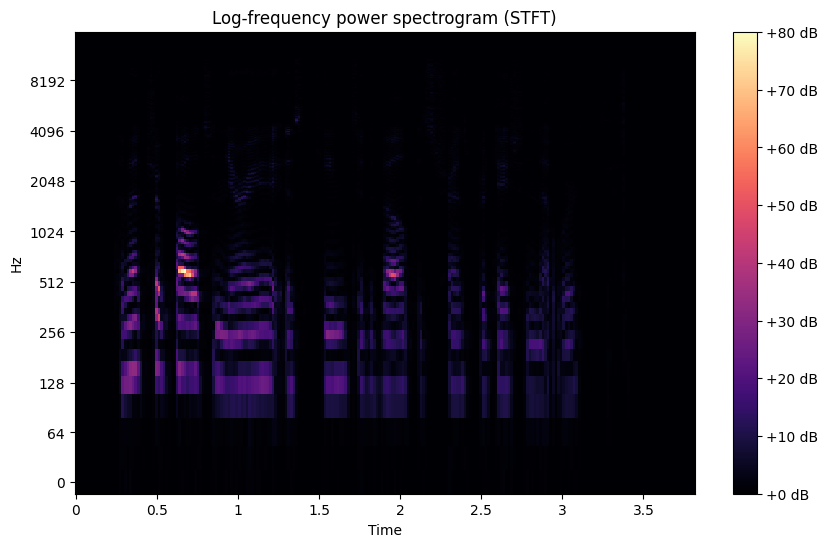

In [69]:
import librosa.display

# Compute Short-Time Fourier Transform (STFT)
D = librosa.stft(audio, n_fft=1024, hop_length=512)
D_db = librosa.amplitude_to_db(D, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram (STFT)')
plt.show()


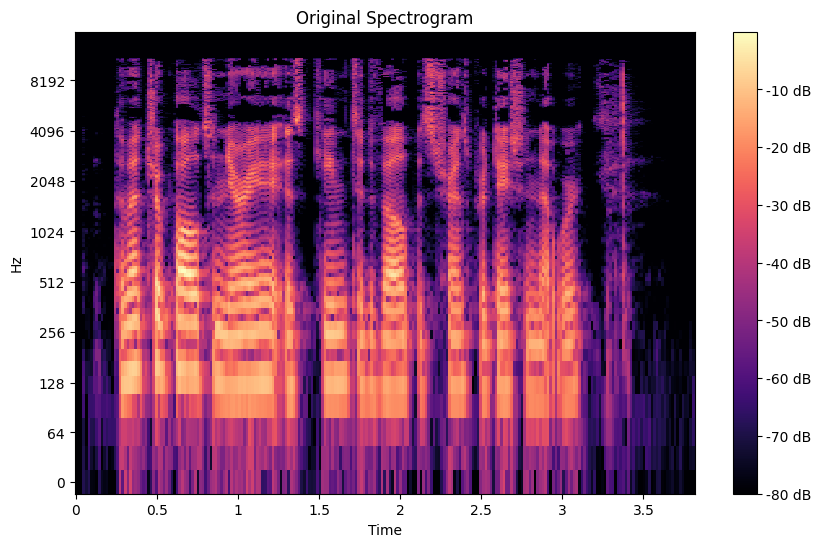

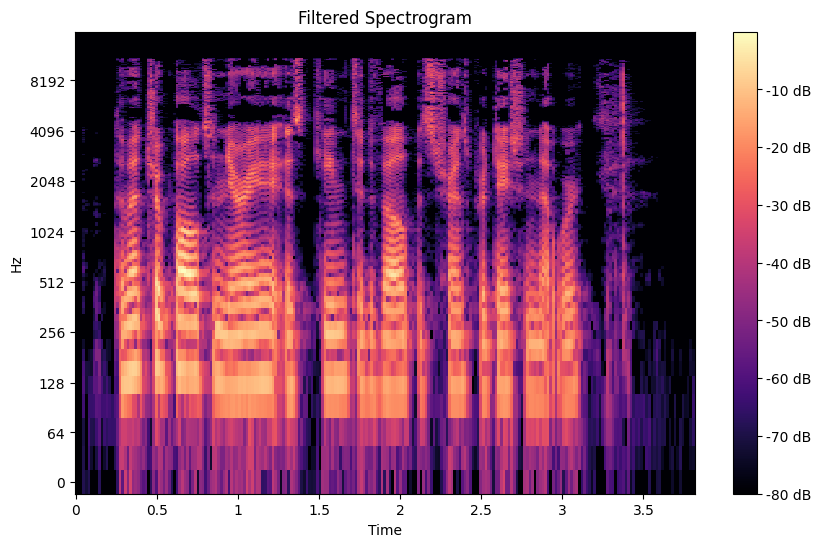

Gini index before noise reduction: 0.7146
Gini index after noise reduction: 0.6375
Gini index of the spectrum before noise reduction: 0.9093
Gini index of the spectrum after noise reduction: 0.9114


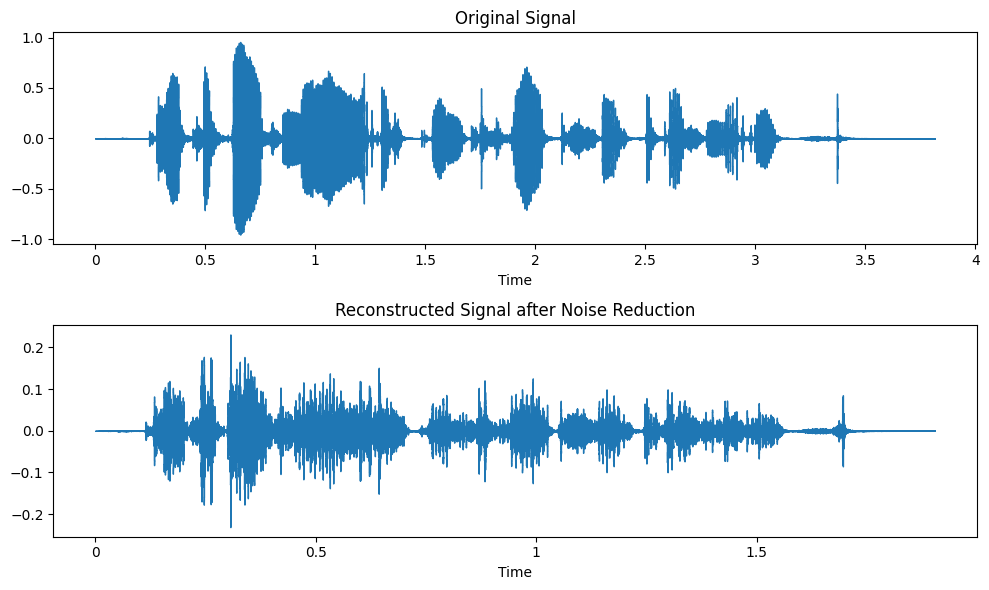

Playing Original Signal
Playing Reconstructed Signal


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

# Function to perform noise reduction using an adaptive threshold
def noise_reduction_adaptive(D, factor=1.5):
    """
    Applies noise reduction by zeroing out values below an adaptive threshold in the frequency domain.
    D: The STFT result (magnitude)
    factor: The factor to multiply the median absolute deviation (MAD) for the threshold.
    """
    # Calculate the median and median absolute deviation (MAD)
    median = np.median(np.abs(D))  # Median of the absolute values of the spectrum
    mad = np.median(np.abs(D - median))  # MAD (Median Absolute Deviation)
    
    # Set threshold as a factor of MAD
    threshold = factor * mad
    
    D_filtered = np.copy(D)
    D_filtered[np.abs(D_filtered) < threshold] = 0  # Zero out values below the threshold
    
    return D_filtered

# Function to compute the Gini index of the signal
def gini_index(signal):
    sorted_signal = np.sort(np.abs(signal))
    cumulative_sum = np.cumsum(sorted_signal)
    lorenz = cumulative_sum / cumulative_sum[-1]  # Normalize to get Lorenz curve
    area = np.sum(lorenz) / len(signal)
    gini = 1 - 2 * area
    return gini

# Function to plot the spectrogram
def plot_spectrogram(D, sr, title="Spectrogram"):
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Function to plot the original and reconstructed signals
def plot_signals(original_signal, reconstructed_signal, sr):
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original_signal, sr=sr)
    plt.title("Original Signal")
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(reconstructed_signal, sr=sr)
    plt.title("Reconstructed Signal after Noise Reduction")
    plt.tight_layout()
    plt.show()

# Load an audio file
audio_path = 'common_voice_en_41910277.mp3'  # Replace with your audio file path
audio, sr = librosa.load(audio_path, sr=sr)  # sr is the sample rate (set to 16kHz)

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(audio, n_fft=1024, hop_length=512)

# Plot the original spectrogram
plot_spectrogram(D, sr, "Original Spectrogram")

# Apply adaptive noise reduction
D_filtered = noise_reduction_adaptive(D, factor=3.0)  # Factor determines the aggressiveness of noise removal

# Plot the filtered spectrogram
plot_spectrogram(D_filtered, sr, "Filtered Spectrogram")

# Reconstruct the signal using the inverse STFT, preserving the phase
# We need to keep both magnitude and phase, so we use the phase from the original STFT
angle = np.angle(D)  # Get the phase from the original STFT
D_filtered_with_phase = D_filtered * np.exp(1j * angle)  # Combine the filtered magnitude with the original phase

# Reconstruct the signal using the inverse STFT
audio_reconstructed = librosa.istft(D_filtered_with_phase)


# Compute and compare Gini indices (sparseness) before and after noise reduction
gini_before = gini_index(audio)
gini_after = gini_index(audio_reconstructed)

print(f"Gini index before noise reduction: {gini_before:.4f}")
print(f"Gini index after noise reduction: {gini_after:.4f}")

# Compare the spectrum before and after noise reduction
# Compute and compare the Gini index of the spectrum (time-frequency domain)
D_flat = D.flatten()
D_filtered_flat = D_filtered.flatten()

gini_spectrum_before = gini_index(D_flat)
gini_spectrum_after = gini_index(D_filtered_flat)

print(f"Gini index of the spectrum before noise reduction: {gini_spectrum_before:.4f}")
print(f"Gini index of the spectrum after noise reduction: {gini_spectrum_after:.4f}")

# Plot the original and reconstructed signals
plot_signals(audio, audio_reconstructed, sr)

# Play the original and reconstructed signals
print("Playing Original Signal")
Audio(audio, rate=sr)

print("Playing Reconstructed Signal")
Audio(audio_reconstructed, rate=sr/2)


Gini index before noise reduction (noisy signal): 0.4854
Gini index after noise reduction (reconstructed signal): 0.5961
Gini index before noise reduction (spectrum): 0.9862
Gini index after noise reduction (spectrum): 0.9862


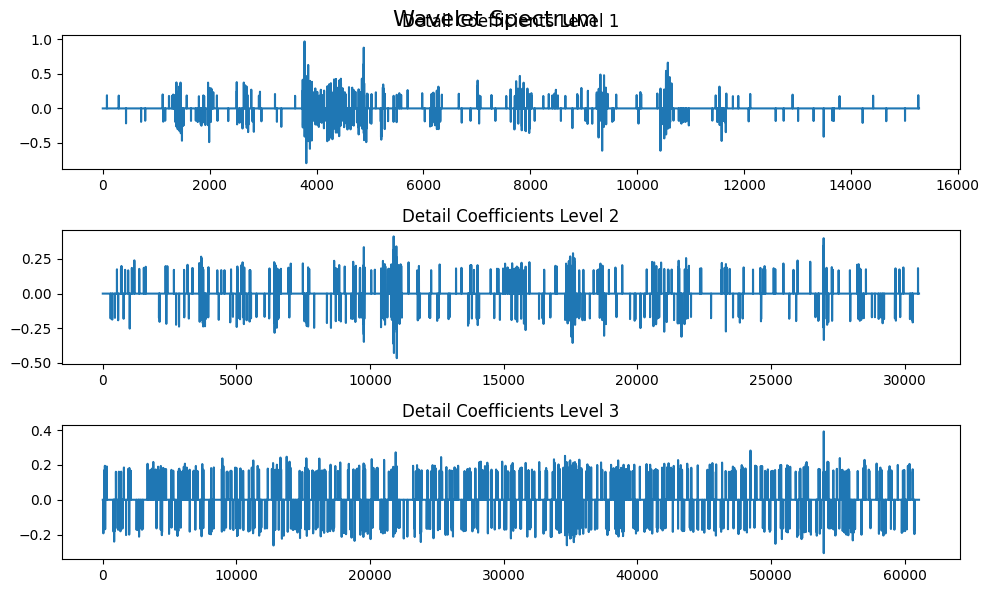

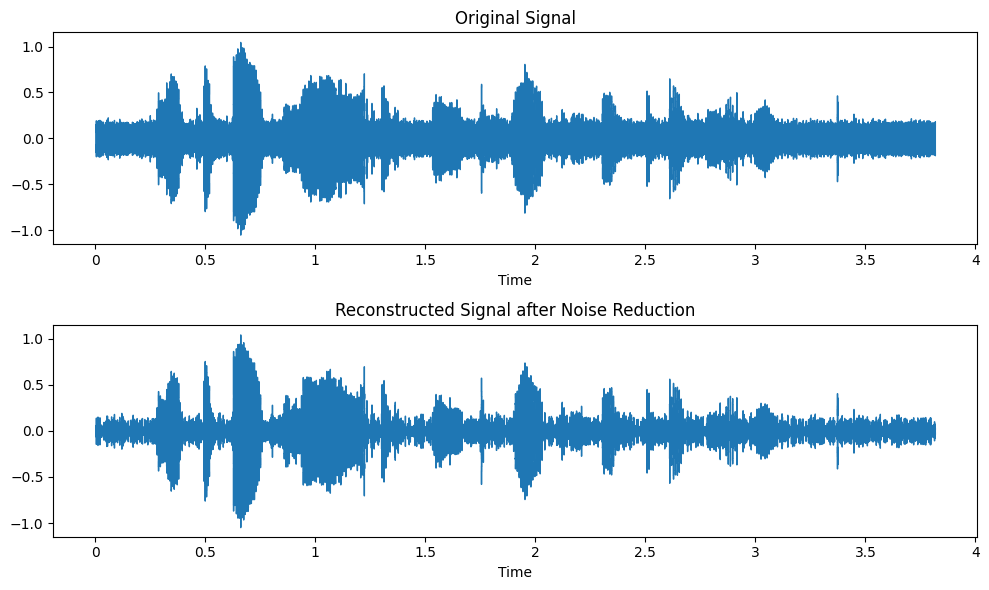

Playing Noisy Signal
Playing Reconstructed Signal


In [113]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pywt
from IPython.display import Audio

# Function to compute the Gini index of a signal
def gini_index(signal):
    sorted_signal = np.sort(np.abs(signal))
    cumulative_sum = np.cumsum(sorted_signal)
    lorenz = cumulative_sum / cumulative_sum[-1]  # Normalize to get Lorenz curve
    area = np.sum(lorenz) / len(signal)
    gini = 1 - 2 * area
    return gini

# Function to add noise to the audio
def add_noise(signal, noise_factor=0.1):
    """
    Adds Gaussian noise to the audio signal.
    signal: The input audio signal.
    noise_factor: The noise level. A higher value adds more noise.
    """
    noise = np.random.normal(0, noise_factor, len(signal))
    noisy_signal = signal + noise
    return noisy_signal

# Function to perform noise reduction using an adaptive threshold in the wavelet domain
def wavelet_noise_reduction(signal, wavelet='db8', level=5, threshold_factor=1.5):
    """
    Applies noise reduction using wavelets by zeroing out coefficients below an adaptive threshold.
    signal: The input signal (audio).
    wavelet: The wavelet type used in the DWT.
    level: The level of decomposition for DWT.
    threshold_factor: The factor to multiply the median absolute deviation (MAD) for the threshold.
    """
    # Perform Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # For each level of decomposition, apply noise reduction
    for i in range(1, len(coeffs)):  # Skip the approximation coefficients (index 0)
        coeffs[i] = noise_reduction_adaptive(coeffs[i], factor=threshold_factor)
    
    # Reconstruct the signal from the denoised coefficients
    denoised_signal = pywt.waverec(coeffs, wavelet)
    
    return coeffs, denoised_signal

# Function to apply adaptive noise reduction (used inside wavelet_noise_reduction)
def noise_reduction_adaptive(D, factor=1.5):
    """
    Applies noise reduction by zeroing out values below an adaptive threshold in the frequency domain.
    D: The DWT coefficient
    factor: The factor to multiply the median absolute deviation (MAD) for the threshold.
    """
    # Calculate the median and median absolute deviation (MAD)
    median = np.median(np.abs(D))  # Median of the absolute values of the spectrum
    mad = np.median(np.abs(D - median))  # MAD (Median Absolute Deviation)
    
    # Set threshold as a factor of MAD
    threshold = factor * mad
    
    D_filtered = np.copy(D)
    D_filtered[np.abs(D_filtered) < threshold] = 0  # Zero out values below the threshold
    
    return D_filtered

# Function to plot the spectrogram of wavelet coefficients
def plot_wavelet_spectrum(coeffs, title="Wavelet Spectrum"):
    plt.figure(figsize=(10, 6))
    
    # Plot detail coefficients for each level of decomposition
    for i, coeff in enumerate(coeffs[1:], 1):  # Skip the approximation (index 0)
        plt.subplot(len(coeffs) - 1, 1, i)
        plt.plot(coeff)
        plt.title(f"Detail Coefficients Level {i}")
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.show()

# Function to plot the original and reconstructed signals
def plot_signals(original_signal, reconstructed_signal, sr):
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original_signal, sr=sr)
    plt.title("Original Signal")
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(reconstructed_signal, sr=sr)
    plt.title("Reconstructed Signal after Noise Reduction")
    plt.tight_layout()
    plt.show()

# Load an audio file
audio_path = 'common_voice_en_41910277.mp3'  # Replace with your audio file path
audio, sr = librosa.load(audio_path, sr=None)  # sr is the sample rate (use original sampling rate)

# Add noise to the original audio signal
noise_factor = 2000 * np.mean(audio)  # Adjust this to control the level of noise
audio_noisy = add_noise(audio, noise_factor=noise_factor)
factor= 3
# Apply wavelet-based noise reduction
coeffs, audio_reconstructed = wavelet_noise_reduction(audio_noisy, wavelet='db8', level=3, threshold_factor=factor)

# Compare the Gini indices (sparseness) before and after noise reduction for the signal
gini_before = gini_index(audio_noisy)
gini_after = gini_index(audio_reconstructed)

print(f"Gini index before noise reduction (noisy signal): {gini_before:.4f}")
print(f"Gini index after noise reduction (reconstructed signal): {gini_after:.4f}")

# Compute the Gini index for the spectrum (wavelet coefficients)
gini_spectrum_before = gini_index(np.concatenate([coeff.flatten() for coeff in coeffs[1:]]))  # Flatten detail coefficients
print(f"Gini index before noise reduction (spectrum): {gini_spectrum_before:.4f}")

# Apply noise reduction and compute the Gini index for the filtered spectrum
coeffs_filtered, _ = wavelet_noise_reduction(audio_reconstructed, wavelet='db8', level=2, threshold_factor=3)
gini_spectrum_after = gini_index(noise_reduction_adaptive(np.concatenate([coeff.flatten() for coeff in coeffs[1:]]),factor= factor))
print(f"Gini index after noise reduction (spectrum): {gini_spectrum_after:.4f}")

# Plot the wavelet spectrum
plot_wavelet_spectrum(coeffs, title="Wavelet Spectrum")

# Plot the original, noisy, and reconstructed signals
plot_signals(audio_noisy, audio_reconstructed, sr)

# Play the original and reconstructed signals
print("Playing Noisy Signal")
Audio(audio_noisy, rate=sr)

print("Playing Reconstructed Signal")
Audio(audio_reconstructed, rate=sr)


In [99]:
# Play the original and reconstructed signals
print("Playing Noisy Signal")
Audio(audio_noisy, rate=sr)

Playing Noisy Signal


In [73]:
from sklearn.datasets import make_sparse_coded_signal
data, dictionary, code = make_sparse_coded_signal(
    n_samples=1,
    n_components=10,

    n_features=7,
    n_nonzero_coefs=3,
    random_state=0
)

In [74]:
dictionary.shape

(10, 7)

In [75]:
print(f'the data shae is {data.shape} \nthe dictionary shape is {dictionary.shape} \nthe code shape is {code.shape}')




the data shae is (7,) 
the dictionary shape is (10, 7) 
the code shape is (10,)
